# Estimate Home Values in Zillow

## Goals:

Your customer is the Zillow data science team. State your goals as if you were delivering this to Zillow. They have asked for something from you and you are basically communicating in a more concise way, and very clearly, the goals as you understand them and as you have taken and acted upon through your research.

#### Brainstorming Process: 
In preparing for this project, I first explored the SQL database where the data was located. I sifted through the information to gain a better sense of what information I would need to pull in, in order to estimate home values. I then decided that I would pull in bedroom count, bathroom count, and square footage to compare to a baseline model. I chose these three features because they were simple and after being ran through the model, proved to show improvement in predictions than the baseline model.

## Import
Import the necessay libraries needed to create a baseline model, and then predict home values. Add libraries as needed throughout the process.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from math import sqrt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

import env
import util
import acquire
import split_scale
import features
import model

First step I loaded the cleaned-up Zillow data from a wrangle.py file, then explored the data for a better understanding of what I am working with. The clean up proccess eliminated null values and changed data types to types more appropriate for the column contents.

In [2]:
df = acquire.acquire_zillow()
df.shape

(14892, 7)

Summary Statistics of data

In [3]:
df.describe()

,bedroom,bathroom,square_feet,tax_amount,home_value,fips
count,14892.000000,14892.000000,14892.000000,14892.000000,1.489200e+04,14892.000000
mean,3.316143,2.324302,1938.497045,6564.370992,5.396460e+05,6049.448429
std,0.926831,1.014254,992.488089,8428.010576,7.290735e+05,21.272489
min,1.000000,1.000000,300.000000,51.260000,1.050400e+04,6037.000000
25%,3.000000,2.000000,1276.000000,2710.622500,1.991870e+05,6037.000000
50%,3.000000,2.000000,1678.000000,4762.040000,3.847785e+05,6037.000000
75%,4.000000,3.000000,2342.250000,7637.557500,6.435572e+05,6059.000000
max,11.000000,11.000000,15450.000000,276797.830000,2.385837e+07,6111.000000


Summary Information of data frame

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14892 entries, 0 to 14892
Data columns (total 7 columns):
bedroom          14892 non-null int64
bathroom         14892 non-null float64
square_feet      14892 non-null int64
tax_amount       14892 non-null float64
home_value       14892 non-null int64
property_type    14892 non-null object
fips             14892 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 930.8+ KB


## Splitting the Data
I used a split function I created, located in a split_scale.py file, to split the data into two peices, train and test. The training data will be 80% of the data and the remaining 20% will be for the test data. I set a random seed at '123'.

In [5]:
train, test = split_scale.split_my_data(df, train_pct=.80, random_state=123)
train.head(), test.head()

(       bedroom  bathroom  square_feet  tax_amount  home_value  \
 7040         2       3.0         2353    13560.29     1121784   
 4866         3       1.0         1085     2581.75      194062   
 2280         3       2.0         1873     4301.71      339756   
 12524        4       3.0         2082     4443.44      376676   
 10726        4       3.5         4364     8876.72      875357   
 
                    property_type  fips  
 7040   Single Family Residential  6037  
 4866   Single Family Residential  6037  
 2280   Single Family Residential  6037  
 12524  Single Family Residential  6059  
 10726  Single Family Residential  6059  ,
        bedroom  bathroom  square_feet  tax_amount  home_value  \
 13487        5       3.0         2504     6257.24      534030   
 6070         3       1.0         1044      882.97       32666   
 4688         3       2.0         1215     2437.92      185287   
 8381         2       1.0         1082     5066.89      408898   
 6079         3    

I then split the train and test pieces even further to establish an 'x' and 'y' variable for both. To establish a baseline, I chose to look at three features in particular, the bedroom count, the bathroom count, and the total square footage of the house. I am assigning the home value as my target variable, since that is what I am looking to predict. 

In [6]:
x_train = train[['bedroom', 'bathroom', 'square_feet']]
y_train = train[['home_value']]
x_test = train[['bedroom', 'bathroom', 'square_feet']]
y_test = train[['home_value']]
print(x_train.head())
print(y_train.head())

       bedroom  bathroom  square_feet
7040         2       3.0         2353
4866         3       1.0         1085
2280         3       2.0         1873
12524        4       3.0         2082
10726        4       3.5         4364
       home_value
7040      1121784
4866       194062
2280       339756
12524      376676
10726      875357


## Scale the data 
I am using the Standard Scaler function I created, located in a split_scale.py file, to scale the data so the difference between square feet and the bedroom/bathroom count can work from the same scale. I am only scaling the x_train and x_test features since I will not be putting my target values into my predictive model, I will instead be predicting those target values with the scaled features.

In [7]:
scaler, x_train, x_test = split_scale.standard_scaler(x_train, x_test)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
x_train.head()

,bedroom,bathroom,square_feet
7040,-1.410430,0.661645,0.406343
4866,-0.338366,-1.299218,-0.853773
2280,-0.338366,-0.318786,-0.070673
12524,0.733697,0.661645,0.137028
10726,0.733697,1.151861,2.404839


## Exploration

Here is a pair plot of all three of my fetures to determine if there is any relation. They are all positively correlated, so I will move forward with them.

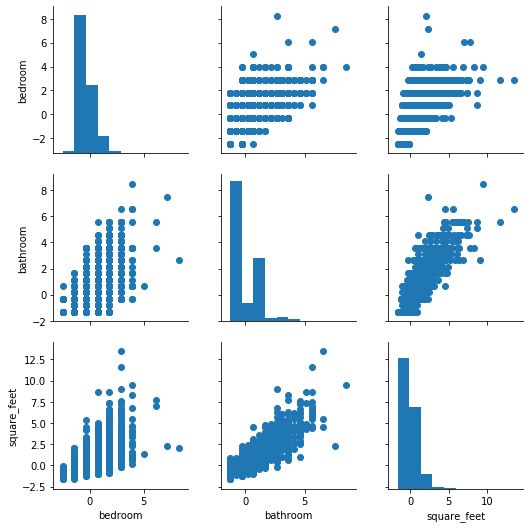

In [9]:
g = sns.PairGrid(x_train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

## Correlation
After scaling my data, I will look at the correlation between my features, bedroom, bathroom, and square footage. I will do so using a heat map to look at the relationships.

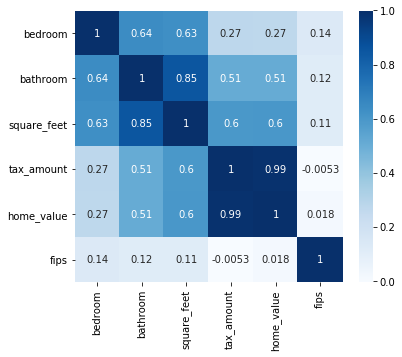

In [22]:
plt.figure(figsize=(6,5))
sns.heatmap(train.corr(), annot=True, cmap=plt.cm.Blues)
plt.show()

## T-Test
I will use an OLS model to find the T-test score of each feature in my model. After plugging in my y_train and x_train(scaled), I see that the P-values are lower than the t-values. 

- Null Hypothesis: The three features have no effect on better predicting home values.

Since the P-values are lower than my alpha, set at 0.05, I reject the null hypothesis.

In [11]:
ols_model = sm.OLS(y_train, x_train).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             home_value   R-squared (uncentered):                   0.251
Model:                            OLS   Adj. R-squared (uncentered):              0.251
Method:                 Least Squares   F-statistic:                              1330.
Date:                Mon, 21 Oct 2019   Prob (F-statistic):                        0.00
Time:                        10:13:53   Log-Likelihood:                     -1.7895e+05
No. Observations:               11913   AIC:                                  3.579e+05
Df Residuals:                   11910   BIC:                                  3.579e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bedroom     -1.431e+05   9875.973    -14.491      0.000   -1.62e+05   -1.24e+05
bathroom     5.025e+04   1.47e+04      3.408      0.001    2.13e+04    7.92e+04
square_feet  5.024e+05   1.46e+04     34.511      0.000    4.74e+05    5.31e+05
==============================================================================
Omnibus:                    19970.509   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         36688147.040
Skew:                          11.065   Prob(JB):                         0.00
Kurtosis:                     273.966   Cond. No.                         4.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Modeling the data

Using a modeling function in model.py, I create a new data frame, 'predictions', to establish a baseline model by taking the mean of my target, home value. I then plug my scaled data into a Linear Regression model within the function and that is added to the newly created data frame. The data frame then outputs the target predictions.

In [12]:
predictions = model.modeling_function(x_train, x_test, y_train, y_test)

In [13]:
predictions.head()

,actual_value,baseline,model1
0,1121784,544122.62948,9.833761e+05
1,194062,544122.62948,9.831026e+04
2,339756,544122.62948,5.410204e+05
3,376676,544122.62948,5.412151e+05
4,875357,544122.62948,1.705229e+06


#### Evaluate scaled model compared to the baseline model.

In [14]:
MSE_base = mean_squared_error(predictions.actual_value, predictions.baseline)
SSE_base = MSE_base * len(predictions.actual_value)
RMSE_base = sqrt(MSE_base)
r2_base = r2_score(predictions.actual_value, predictions.baseline)
print(MSE_base, SSE_base, RMSE_base, r2_base)

575225329640.1548 6852659352003164.0 758436.1078167064 0.0


#### Model Error

In [15]:
MSE_1 = mean_squared_error(predictions.actual_value, predictions.model1)
SSE_1 = MSE_1 * len(predictions.actual_value)
RMSE_1 = sqrt(MSE_1)
r2_1 = r2_score(predictions.actual_value, predictions.model1)
print(MSE_1,SSE_1,RMSE_1,r2_1)

356640202824.1915 4248654736244593.5 597193.6058132167 0.37999913347471004


I created a data frame to show the differences between the baseline model and scaled model to see side-by-side, and the amount of error between the two models.

In [16]:
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE', 'R^2']), columns=['metric'])
df_eval['baseline_error'] = np.array([SSE_base, MSE_base, RMSE_base, r2_base])
df_eval['model_error'] = np.array([SSE_1, MSE_1, RMSE_1, r2_1])
df_eval['error_delta'] = df_eval.model_error - df_eval.baseline_error
df_eval

,metric,baseline_error,model_error,error_delta
0,SSE,6.852659e+15,4.248655e+15,-2.604005e+15
1,MSE,5.752253e+11,3.566402e+11,-2.185851e+11
2,RMSE,7.584361e+05,5.971936e+05,-1.612425e+05
3,R^2,0.000000e+00,3.799991e-01,3.799991e-01


## Conclusions
With an R^2 value of about 38%, you can see that the Linear Regression model does better with the three choosen features than the baseline model.

In [17]:
model1 = LinearRegression()
model1.fit(x_train, y_train)
model1_predictions = model1.predict(x_train)
predictions['model1'] = model1_predictions

baseline = y_train.mean()

actuals = y_train.home_value


def plot_linear_model(actuals, model1_predictions, baseline):
    plot = pd.DataFrame({'actual': actuals,
                'linear model': model1_predictions.ravel(),
                'baseline': baseline.ravel()})\
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')
    
    plt.plot([predictions.actuals.min(),predictions.actuals.max()],[predictions.lm.min(),predictions.lm.max()], \
    c='black', ls=':', linewidth = 3)
    return plot

plot_linear_model(actuals, model1, baseline)

AttributeError: 'LinearRegression' object has no attribute 'ravel'

# County Tax Rate Distribution

Create a new column in the data frame to calculate the 'tax rate'.

In [18]:
df['tax_rate'] = df['tax_amount']/df['home_value']
df.head()

,bedroom,bathroom,square_feet,tax_amount,home_value,property_type,fips,tax_rate
0,3,2.0,1458,2319.90,136104,Single Family Residential,6037,0.017045
1,2,1.0,1421,543.69,35606,Single Family Residential,6037,0.015270
2,3,2.0,1650,7673.19,614000,Single Family Residential,6037,0.012497
3,2,1.0,693,3267.47,274237,Single Family Residential,6037,0.011915
4,3,2.0,1108,5990.50,486866,Single Family Residential,6037,0.012304


Create a new column, 'county_name', and assign the correct county name to the corresponding FIPS number. The county name for each FIPS number was found on https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697 . Perform a .groupby() and a .count() to get the total count of each FIPS number per tax rate.

In [19]:
df['county_name'] = df['fips'].map({6037: "Los_Angeles_County", 6059: "Orange_County", 6111: "Ventura_County"})
df.head()
df_county = df[['fips', 'county_name','tax_rate']]
df_county.head()

,fips,county_name,tax_rate
0,6037,Los_Angeles_County,0.017045
1,6037,Los_Angeles_County,0.015270
2,6037,Los_Angeles_County,0.012497
3,6037,Los_Angeles_County,0.011915
4,6037,Los_Angeles_County,0.012304


In [20]:
df_county.groupby('county_name').tax_rate.count()

county_name
Los_Angeles_County    9517
Orange_County         4084
Ventura_County        1291
Name: tax_rate, dtype: int64

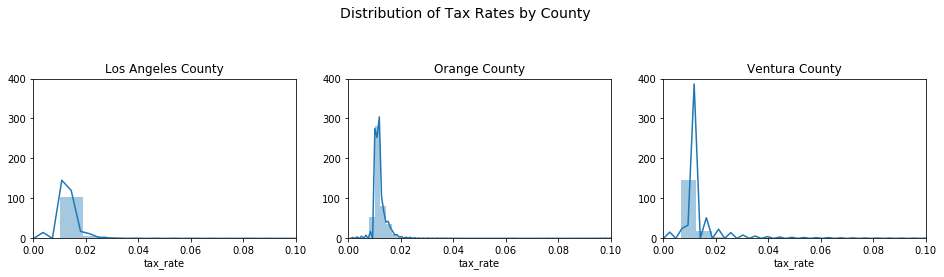

In [21]:
la = df_county[df_county.county_name == "Los_Angeles_County"].tax_rate
oc = df_county[df_county.county_name == "Orange_County"].tax_rate
v = df_county[df_county.county_name == "Ventura_County"].tax_rate

plt.figure(figsize=(16, 10))
plt.suptitle("Distribution of Tax Rates by County", fontsize=14)
plt.subplot(331)
sns.distplot(la, bins=50)
plt.xlim(0, .10)
plt.ylim(0, 400)
plt.title("Los Angeles County")
plt.subplot(332)
sns.distplot(oc, bins=50)
plt.xlim(0, .10)
plt.ylim(0, 400)
plt.title("Orange County")
plt.subplot(333)
sns.distplot(v, bins=50)
plt.xlim(0, .10)
plt.ylim(0, 400)
plt.title("Ventura County")
plt.show()